In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import classification_report, scorer, precision_score, recall_score

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.width', 4000)
pd.set_option('max_colwidth', 4000)
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

In [4]:
os.chdir('/Users/Weiyang/Desktop/Git/Assignment/Assignment2/Data')

In [5]:
dataset = pd.read_csv('telco-churn.csv', delimiter = ',')

### Inspecting Data

In [6]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
print ("Rows     : " ,dataset.shape[0])
print ("Columns  : " ,dataset.shape[1])
print ("\nFeatures : \n" ,dataset.columns.tolist())
print ("\nMissing values :  ", dataset.isnull().sum().values.sum())
print ("\nUnique values :  \n",dataset.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


### Data Manipulation

#### For Total Charges

In [8]:
dataset['TotalCharges'] = dataset["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
dataset = dataset[dataset["TotalCharges"].notnull()]
dataset = dataset.reset_index()[dataset.columns]

#convert to float type
dataset["TotalCharges"] = dataset["TotalCharges"].astype(float)

#### Re-Classifying No Internet Service to No

In [9]:
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']

for i in replace_cols : 
    dataset[i]  = dataset[i].replace({'No internet service' : 'No'})
    
dataset["SeniorCitizen"] = dataset["SeniorCitizen"].replace({1:"Yes",0:"No"})

#### Seperating Churn and Non-Churn Customers

In [10]:
churn = dataset[dataset["Churn"] == "Yes"]
not_churn = dataset[dataset["Churn"] == "No"]

### Data Pre-Processing

#### Seperating into Categorical and Numerical Columns

In [11]:
Id_col = ['customerID']
target_col = ["Churn"]

#categorical columns
categorical_cols   = dataset.nunique()[dataset.nunique() < 6].keys().tolist()
categorical_cols   = [x for x in categorical_cols if x not in target_col]

#numerical columns
numerical_cols   = [x for x in dataset.columns if x not in categorical_cols + target_col + Id_col]

#Binary columns with 2 values
binary_cols   = dataset.nunique()[dataset.nunique() == 2].keys().tolist()

#Columns more than 2 values
multi_cols = [i for i in categorical_cols if i not in binary_cols]

#### Label Encoding Binary Columns

In [12]:
le = LabelEncoder()

for i in binary_cols :
    dataset[i] = le.fit_transform(dataset[i])

#### Dummy Variables for Multi-categorical Columns

In [13]:
dataset = pd.get_dummies(data = dataset,columns = multi_cols)

#### Scaling Numerical Values

In [14]:
std = MinMaxScaler()

scaled = std.fit_transform(dataset[numerical_cols])
scaled = pd.DataFrame(scaled,columns=numerical_cols)

#### Final Pre-processing

In [15]:
df_telcom = dataset.copy()

dataset = dataset.drop(numerical_cols,axis = 1)
dataset = dataset.merge(scaled,left_index=True,right_index=True,how = "left")

### Performing Random Sampling to cut down Dataset Size for Faster Processing

In [16]:
import random

In [18]:
dataset = dataset.sample(395)

##### This has been made the same size as the comparative Student Performance Dataset

In [20]:
dataset.shape

(395, 30)

### Seperating Data into Train & Test

In [21]:
y_labels = dataset.pop('Churn')

In [22]:
dataset = dataset.drop(['customerID'], axis=1)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(dataset, y_labels, test_size = 0.33, random_state = 777)

In [24]:
print(x_train.shape)

(264, 28)


In [25]:
print(y_train.shape)

(264,)


In [26]:
print(x_test.shape)

(131, 28)


In [27]:
print(y_test.shape)

(131,)


## Support Vector Machine (With Feature Scaling)

### Using Linear Kernel

In [28]:
# Create the SVC model object
C = 1.0 # SVM regularization parameter

In [29]:
svc_linear = svm.SVC(kernel='linear', C=C, decision_function_shape='ovr', probability = True).fit(x_train, y_train)

In [30]:
predictions = svc_linear.predict(x_test)

In [31]:
cm = confusion_matrix(y_test, predictions)

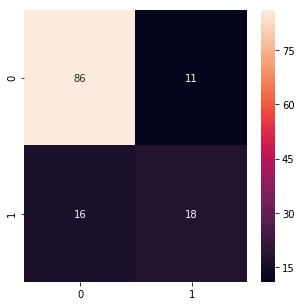

In [32]:
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, fmt="d")

In [33]:
# calculate the fpr and tpr for all thresholds of the classification
probs = svc_linear.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

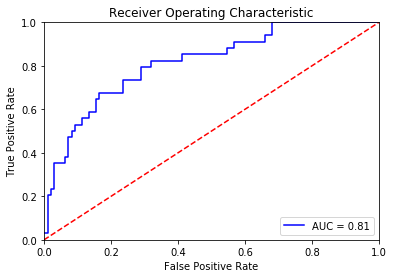

In [34]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
score = round(accuracy_score(y_test, svc_linear.predict(x_test)),2)

print('Accuracy of SVM: {} '.format(score))

Accuracy of SVM: 0.79 


### Using RBF Kernel

In [36]:
# Create the SVC model object
C = 1.0 # SVM regularization parameter

In [37]:
svc_rbf = svm.SVC(kernel='rbf', C=C, decision_function_shape='ovr', probability = True).fit(x_train, y_train)

In [38]:
predictions = svc_rbf.predict(x_test)

In [39]:
cm = confusion_matrix(y_test, predictions)

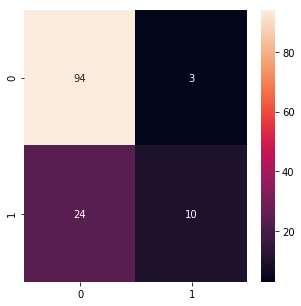

In [40]:
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, fmt="d")

In [41]:
# calculate the fpr and tpr for all thresholds of the classification
probs = svc_rbf.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

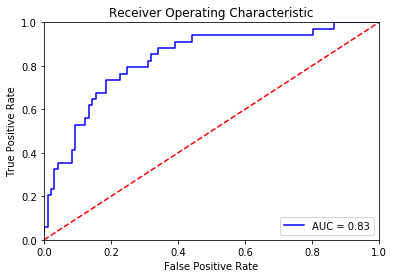

In [42]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
score = round(accuracy_score(y_test, svc_rbf.predict(x_test)),2)

print('Accuracy of SVM: {} '.format(score))

Accuracy of SVM: 0.79 


### Using polynomial Kernel

#### Default degree of the polynomial kernel function is 3

In [44]:
# Create the SVC model object
C = 1.0 # SVM regularization parameter

In [45]:
svc_poly = svm.SVC(kernel='poly', C=C, decision_function_shape='ovr', probability = True).fit(x_train, y_train)

In [46]:
predictions = svc_poly.predict(x_test)

In [47]:
cm = confusion_matrix(y_test, predictions)

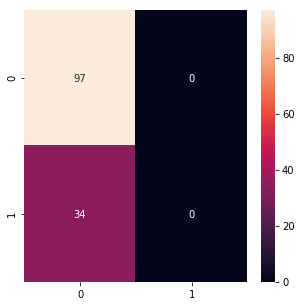

In [48]:
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, fmt="d")

In [49]:
# calculate the fpr and tpr for all thresholds of the classification
probs = svc_poly.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

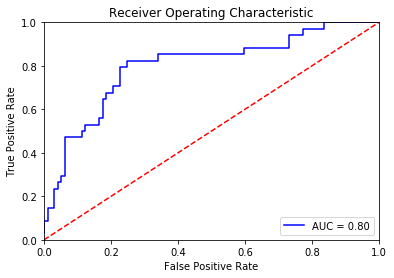

In [50]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [51]:
score = round(accuracy_score(y_test, svc_poly.predict(x_test)),2)

print('Accuracy of SVM: {} '.format(score))

Accuracy of SVM: 0.74 


#### Sci-kit Learn Code for Learning Curves

from sklearn.model_selection import learning_curve

In [52]:
# Function to plot a learning curve.
# Taken from http://scikit-learn.org/dev/_downloads/plot_learning_curve.py

def plot_learning_curve(estimator, plot_title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        null for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """    
    from sklearn.learning_curve import learning_curve
    
    plt.figure()
    plt.title(plot_title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Cost = 1 - Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, n_jobs=n_jobs,
                                                            train_sizes=train_sizes,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, 1 - train_scores_mean + train_scores_std,
                     1 - train_scores_mean - train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, 1 - test_scores_mean + test_scores_std,
                     1 - test_scores_mean - test_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, 1 - train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, 1 - test_scores_mean, 'o-', color="r",
             label="Test score")

    plt.legend(loc="best")
    plt.show()

In [53]:
def plot_validation_curve(train_scores, test_scores, title, xlabel, param_range):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    #plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [54]:
def plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    #plt.ylim(0.0, 1.1)
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy")
    plt.legend(loc="best")
    plt.show()

### Comparing 3 different SVM Kernels

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


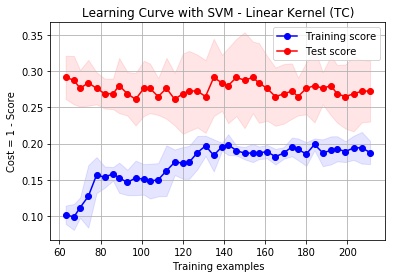

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


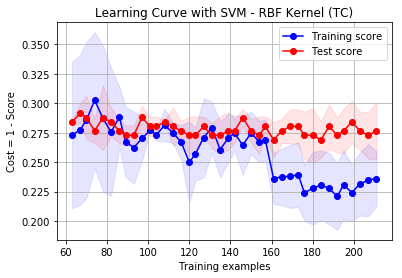

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


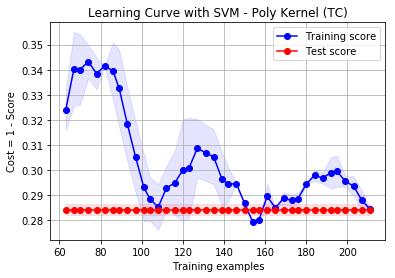

In [122]:
title1 = 'Learning Curve with SVM - Linear Kernel (TC)'
title2 = 'Learning Curve with SVM - RBF Kernel (TC)'
title3 = 'Learning Curve with SVM - Poly Kernel (TC)'

plot_learning_curve(svc_linear, title1, x_train, y_train, cv=5, n_jobs=1, train_sizes=np.linspace(.3, 1.0, 40))
plot_learning_curve(svc_rbf, title2, x_train, y_train, cv=5, n_jobs=1, train_sizes=np.linspace(.3, 1.0, 40))
plot_learning_curve(svc_poly, title3, x_train, y_train, cv=5, n_jobs=1, train_sizes=np.linspace(.3, 1.0, 40))

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


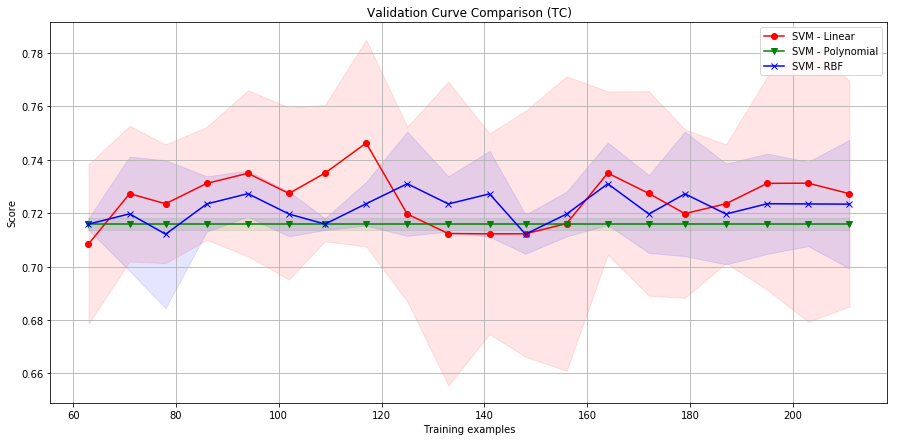

In [123]:
train_sizes = np.linspace(.3, 1.0, 20)
train_sizes_linear, train_scores_linear, test_scores_linear = learning_curve(svc_linear, x_train, y_train, cv=5, n_jobs=1, train_sizes=train_sizes)
train_sizes_poly, train_scores_poly, test_scores_poly = learning_curve(svc_poly, x_train, y_train, cv=5, n_jobs=1, train_sizes=train_sizes)
train_sizes_rbf, train_scores_rbf, test_scores_rbf = learning_curve(svc_rbf, x_train, y_train, cv=5, n_jobs=1, train_sizes=train_sizes)

plt.figure(figsize=(15,7))
plt.title('Validation Curve Comparison (TC)')
plt.xlabel("Training examples")
plt.ylabel("Score")
test_scores_mean_linear = np.mean(test_scores_linear, axis=1)
test_scores_std_linear = np.std(test_scores_linear, axis=1)
test_scores_mean_poly = np.mean(test_scores_poly, axis=1)
test_scores_std_poly = np.std(test_scores_poly, axis=1)
test_scores_mean_rbf = np.mean(test_scores_rbf, axis=1)
test_scores_std_rbf = np.std(test_scores_rbf, axis=1)

plt.fill_between(train_sizes_linear, test_scores_mean_linear - test_scores_std_linear,
                 test_scores_mean_linear + test_scores_std_linear, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_poly, test_scores_mean_poly - test_scores_std_poly,
                 test_scores_mean_poly + test_scores_std_poly, alpha=0.1, color="g")
plt.fill_between(train_sizes_rbf, test_scores_mean_rbf - test_scores_std_rbf,
                 test_scores_mean_rbf + test_scores_std_rbf, alpha=0.1, color="b")


plt.plot(train_sizes_linear, test_scores_mean_linear, 'o-', color="r",
         label="SVM - Linear")
plt.plot(train_sizes_poly, test_scores_mean_poly, 'v-', color="g",
         label="SVM - Polynomial")
plt.plot(train_sizes_rbf, test_scores_mean_rbf, 'x-', color="b",
         label="SVM - RBF")
plt.grid()
plt.legend(loc="best")

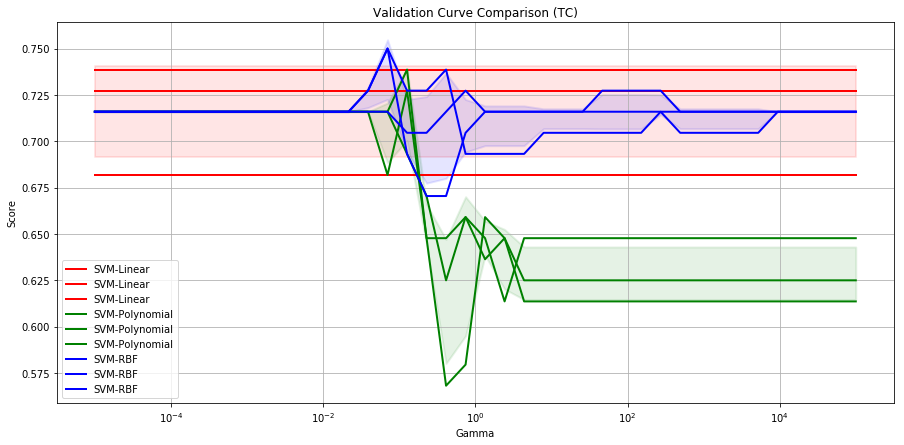

In [125]:
param_range = np.logspace(-5,5,40)
train_scores_linear, test_scores_linear = validation_curve(svc_linear, x_train, y_train, n_jobs=1, param_name='gamma', param_range=param_range)
train_scores_poly, test_scores_poly = validation_curve(svc_poly, x_train, y_train, n_jobs=1, param_name='gamma', param_range=param_range)
train_scores_rbf, test_scores_rbf = validation_curve(svc_rbf, x_train, y_train, n_jobs=1, param_name='gamma', param_range=param_range)

plt.figure(figsize=(15,7))
plt.title('Validation Curve Comparison (TC)')
plt.xlabel("Gamma")
plt.ylabel("Score")
lw=2
test_scores_mean_linear = np.mean(test_scores_linear, axis=1)
test_scores_std_linear = np.std(test_scores_linear, axis=1)
test_scores_mean_poly = np.mean(test_scores_poly, axis=1)
test_scores_std_poly = np.std(test_scores_poly, axis=1)
test_scores_mean_rbf = np.mean(test_scores_rbf, axis=1)
test_scores_std_rbf = np.std(test_scores_rbf, axis=1)

plt.semilogx(param_range, test_scores_linear, label="SVM-Linear", lw=lw, color="r")
plt.fill_between(param_range, test_scores_mean_linear - test_scores_std_linear,
                 test_scores_mean_linear + test_scores_std_linear, alpha=0.1,
                 color="r", lw=lw)

plt.semilogx(param_range, test_scores_poly, label="SVM-Polynomial", lw=lw, color="g")
plt.fill_between(param_range, test_scores_mean_poly - test_scores_std_poly,
                 test_scores_mean_poly + test_scores_std_poly, alpha=0.1, color="g", lw=lw)

plt.semilogx(param_range, test_scores_rbf, label="SVM-RBF", lw=lw, color="b")
plt.fill_between(param_range, test_scores_mean_rbf - test_scores_std_rbf,
                 test_scores_mean_rbf + test_scores_std_rbf, alpha=0.1, color="b", lw=lw)

plt.grid()
plt.legend(loc="best")

## Using Decision Tree

In [92]:
decision_tree = DecisionTreeClassifier(criterion='gini', random_state=777).fit(x_train, y_train)

In [93]:
predictions = decision_tree.predict(x_test)

In [94]:
cm = confusion_matrix(y_test, predictions)

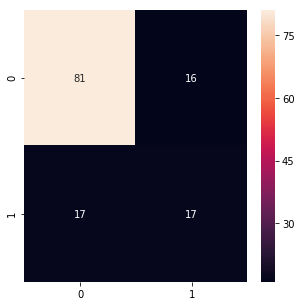

In [95]:
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, fmt="d")

In [96]:
# calculate the fpr and tpr for all thresholds of the classification
probs = decision_tree.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

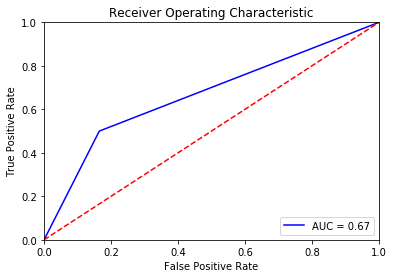

In [97]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [99]:
score = round(accuracy_score(y_test, decision_tree.predict(x_test)),2)

print('Accuracy of Decision Tree: {} '.format(score))

Accuracy of Decision Tree: 0.75 


In [117]:
print('Accuracy for Decision Tree: {}'.format(decision_tree.score(x_test, y_test)))

Accuracy for Decision Tree: 0.7480916030534351


## Using Random Forest

In [100]:
random_forest = RandomForestClassifier(criterion='gini', random_state=777).fit(x_train, y_train)

In [101]:
predictions = random_forest.predict(x_test)

In [102]:
cm = confusion_matrix(y_test, predictions)

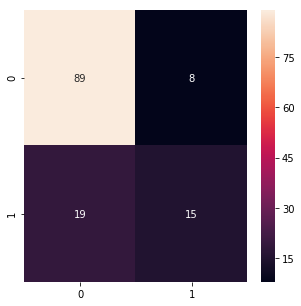

In [103]:
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, fmt="d")

In [104]:
# calculate the fpr and tpr for all thresholds of the classification
probs = random_forest.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

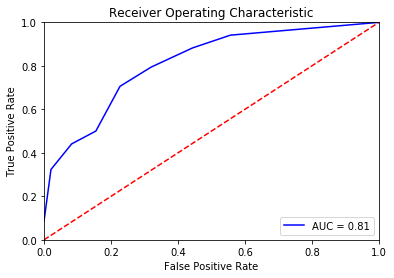

In [105]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [106]:
score = round(accuracy_score(y_test, random_forest.predict(x_test)),2)

print('Accuracy of Random Forest: {} '.format(score))

Accuracy of Random Forest: 0.79 


## Using Gradient Boosted Classifier

In [109]:
gradient_boosted_classifier = GradientBoostingClassifier(learning_rate = 1, random_state=777).fit(x_train, y_train)

In [110]:
predictions = gradient_boosted_classifier.predict(x_test)

In [111]:
cm = confusion_matrix(y_test, predictions)

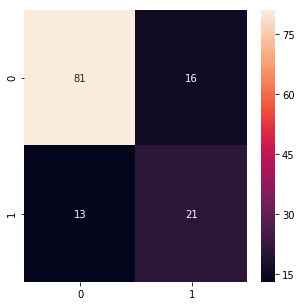

In [112]:
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, fmt="d")

In [113]:
# calculate the fpr and tpr for all thresholds of the classification
probs = gradient_boosted_classifier.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

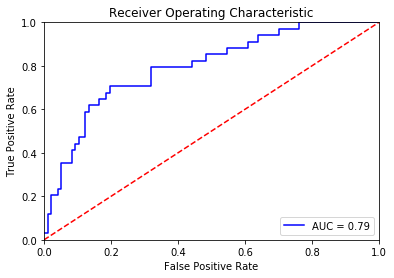

In [114]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [116]:
score = round(accuracy_score(y_test, gradient_boosted_classifier.predict(x_test)),2)

print('Accuracy of Gradient Boosted Classifier: {} '.format(score))

Accuracy of Gradient Boosted Classifier: 0.78 


## Hyper-parameter Tuning

### Hyper-parameter tuning for SVM

In [58]:
# Set the parameters by cross-validation
parameters = [{'kernel': ['rbf'],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                'C': [0.01, 0.1, 1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000]},
             {'kernel': ['poly'],
             'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
             'C': [0.01, 0.1, 1, 10, 100, 1000]}]

print("# Tuning hyper-parameters for SVM")
print()

model1 = svm.SVC(decision_function_shape='over', probability=True)
clf = GridSearchCV(estimator=model1, param_grid=parameters, cv=10)
clf.fit(x_train, y_train)

print("Best parameters set found on Cross-Validation set:")
print()
print(clf.best_params_)
print()
print("Grid scores on training set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for SVM

Best parameters set found on Cross-Validation set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on training set:

0.716 (+/-0.026) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.01, 'gamma': 0.2, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.01, 'gamma': 0.5, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.1, 'gamma': 0.2, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}
0.716 (+/-0.026) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.716 (+/-0.

##### Plotting Learning Curves

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


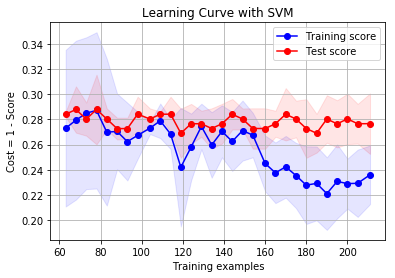

In [59]:
clf_learning = svm.SVC(decision_function_shape='ovr',random_state=777)

title = 'Learning Curve with SVM'
plot_learning_curve(clf_learning, title, x_train, y_train, cv=5, n_jobs=1, train_sizes=np.linspace(.3, 1.0, 30))

##### Plotting Validation Curves for Gamma Values

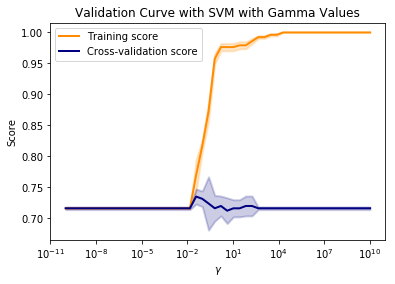

In [60]:
clf_valid = svm.SVC(decision_function_shape='ovr', random_state=777)

param_range = np.logspace(-10, 10, 50)
train_scores, test_scores = validation_curve(
    clf_valid, x_train, y_train, param_name="gamma", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)

title = "Validation Curve with SVM with Gamma Values"
xlabel = "$\gamma$"
plot_validation_curve(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for C Values

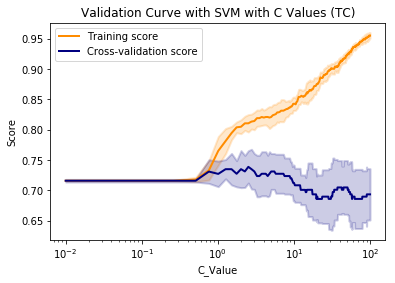

In [126]:
clf_valid = svm.SVC(decision_function_shape='ovr', random_state=777)

param_range = np.linspace(0.01, 100, 400)
train_scores, test_scores = validation_curve(
    clf_valid, x_train, y_train, param_name="C", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)

title = "Validation Curve with SVM with C Values (TC)"
xlabel = "C_Value"
plot_validation_curve(train_scores, test_scores, title, xlabel, param_range)

## Decision Tree Classifier (with Feature Scaling)

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [64]:
# Set the parameters by cross-validation
parameters = {'min_samples_split' : range(10,200,20),'max_depth': range(1,10,2), 'max_features': range(1,28,2)}

print("# Tuning hyper-parameters for Decision Tree")
print()

clf_tree = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10)
clf_tree.fit(x_train, y_train)

print("Best parameters set found on Cross-Validation set:")
print()
print(clf_tree.best_params_)
print()
print("Grid scores on training set:")
print()
means = clf_tree.cv_results_['mean_test_score']
stds = clf_tree.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_tree.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for Decision Tree

Best parameters set found on Cross-Validation set:

{'max_depth': 9, 'max_features': 25, 'min_samples_split': 50}

Grid scores on training set:

0.723 (+/-0.047) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 10}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 30}
0.735 (+/-0.107) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 50}
0.708 (+/-0.043) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 70}
0.705 (+/-0.064) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 90}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 110}
0.720 (+/-0.040) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 130}
0.723 (+/-0.044) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 150}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 170}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_sample

0.727 (+/-0.046) for {'max_depth': 7, 'max_features': 17, 'min_samples_split': 150}
0.758 (+/-0.103) for {'max_depth': 7, 'max_features': 17, 'min_samples_split': 170}
0.731 (+/-0.074) for {'max_depth': 7, 'max_features': 17, 'min_samples_split': 190}
0.727 (+/-0.136) for {'max_depth': 7, 'max_features': 19, 'min_samples_split': 10}
0.731 (+/-0.151) for {'max_depth': 7, 'max_features': 19, 'min_samples_split': 30}
0.731 (+/-0.132) for {'max_depth': 7, 'max_features': 19, 'min_samples_split': 50}
0.780 (+/-0.138) for {'max_depth': 7, 'max_features': 19, 'min_samples_split': 70}
0.758 (+/-0.103) for {'max_depth': 7, 'max_features': 19, 'min_samples_split': 90}
0.780 (+/-0.134) for {'max_depth': 7, 'max_features': 19, 'min_samples_split': 110}
0.739 (+/-0.100) for {'max_depth': 7, 'max_features': 19, 'min_samples_split': 130}
0.731 (+/-0.077) for {'max_depth': 7, 'max_features': 19, 'min_samples_split': 150}
0.735 (+/-0.089) for {'max_depth': 7, 'max_features': 19, 'min_samples_split': 17

##### Plotting Learning Curves

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


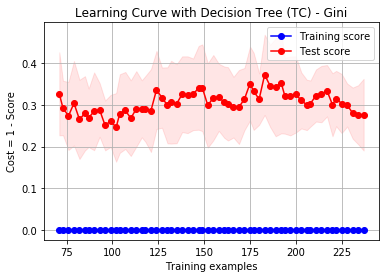

In [128]:
clf_tree_learning = DecisionTreeClassifier(criterion='gini', random_state=777)

title = 'Learning Curve with Decision Tree (TC) - Gini'
plot_learning_curve(clf_tree_learning, title, x_train, y_train, cv=10, train_sizes=np.linspace(.3, 1.0, 60))

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


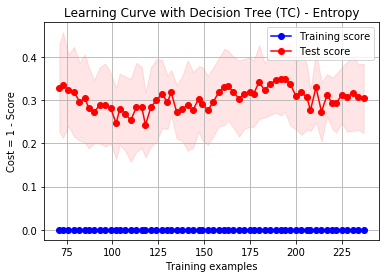

In [129]:
clf_tree_learning = DecisionTreeClassifier(criterion='entropy', random_state=777)

title = 'Learning Curve with Decision Tree (TC) - Entropy'
plot_learning_curve(clf_tree_learning, title, x_train, y_train, cv=10, train_sizes=np.linspace(.3, 1.0, 60))

##### Plotting Validation Curves for Maximum Features

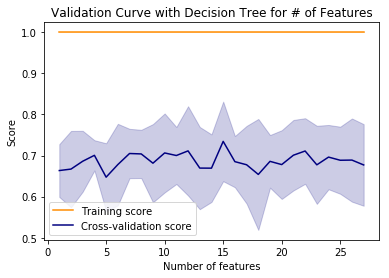

In [66]:
clf_tree_valid = DecisionTreeClassifier(criterion='gini',random_state=777)

param_range = [i for i in range(1,x_train.shape[1])]
train_scores, test_scores = validation_curve(
    clf_tree_valid, x_train, y_train, param_name="max_features", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Decision Tree for # of Features"
xlabel = "Number of features"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for Minimum Samples Split

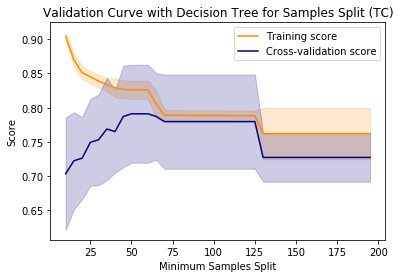

In [130]:
clf_tree_valid = DecisionTreeClassifier(criterion='gini',random_state=777)

param_range = list(range(10,200,5))
train_scores, test_scores = validation_curve(
    clf_tree_valid, x_train, y_train, param_name="min_samples_split", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Decision Tree for Samples Split (TC)"
xlabel = "Minimum Samples Split"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for Maximum Depth

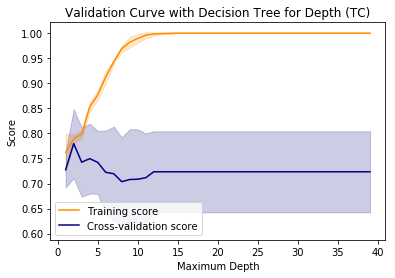

In [131]:
clf_tree_valid = DecisionTreeClassifier(criterion='gini',random_state=777)

param_range = list(range(1,40,1))
train_scores, test_scores = validation_curve(
    clf_tree_valid, x_train, y_train, param_name="max_depth", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Decision Tree for Depth (TC)"
xlabel = "Maximum Depth"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for Maximum Leaf Nodes

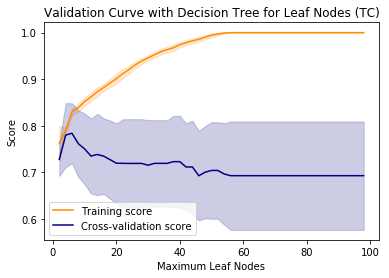

In [132]:
clf_tree_valid = DecisionTreeClassifier(criterion='gini',random_state=777)

param_range = list(range(2,100,2))
train_scores, test_scores = validation_curve(
    clf_tree_valid, x_train, y_train, param_name="max_leaf_nodes", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Decision Tree for Leaf Nodes (TC)"
xlabel = "Maximum Leaf Nodes"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for Minimum Samples Leaf

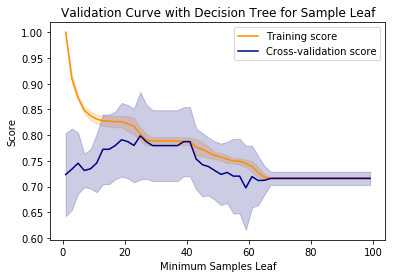

In [70]:
clf_tree_valid = DecisionTreeClassifier(criterion='gini',random_state=777)

param_range = list(range(1,100,2))
train_scores, test_scores = validation_curve(
    clf_tree_valid, x_train, y_train, param_name="min_samples_leaf", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Decision Tree for Sample Leaf"
xlabel = "Minimum Samples Leaf"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

## Random Tree Classifier (with Feature Scaling)

In [71]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
# Set the parameters by cross-validation
parameters = {'min_samples_split' : range(10,200,20),'max_depth': range(1,10,2), 'max_features': range(1,28,2)}

print("# Tuning hyper-parameters for Random Forest")
print()

clf_rf = GridSearchCV(RandomForestClassifier(), parameters, cv=10)
clf_rf.fit(x_train, y_train)

print("Best parameters set found on Cross-Validation set:")
print()
print(clf_rf.best_params_)
print()
print("Grid scores on training set:")
print()
means = clf_rf.cv_results_['mean_test_score']
stds = clf_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for Random Forest

Best parameters set found on Cross-Validation set:

{'max_depth': 9, 'max_features': 11, 'min_samples_split': 50}

Grid scores on training set:

0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 10}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 30}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 50}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 70}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 90}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 110}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 130}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 150}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_samples_split': 170}
0.716 (+/-0.026) for {'max_depth': 1, 'max_features': 1, 'min_sample

0.765 (+/-0.097) for {'max_depth': 3, 'max_features': 25, 'min_samples_split': 70}
0.773 (+/-0.139) for {'max_depth': 3, 'max_features': 25, 'min_samples_split': 90}
0.758 (+/-0.112) for {'max_depth': 3, 'max_features': 25, 'min_samples_split': 110}
0.769 (+/-0.101) for {'max_depth': 3, 'max_features': 25, 'min_samples_split': 130}
0.727 (+/-0.060) for {'max_depth': 3, 'max_features': 25, 'min_samples_split': 150}
0.716 (+/-0.026) for {'max_depth': 3, 'max_features': 25, 'min_samples_split': 170}
0.716 (+/-0.026) for {'max_depth': 3, 'max_features': 25, 'min_samples_split': 190}
0.769 (+/-0.137) for {'max_depth': 3, 'max_features': 27, 'min_samples_split': 10}
0.765 (+/-0.077) for {'max_depth': 3, 'max_features': 27, 'min_samples_split': 30}
0.765 (+/-0.133) for {'max_depth': 3, 'max_features': 27, 'min_samples_split': 50}
0.773 (+/-0.153) for {'max_depth': 3, 'max_features': 27, 'min_samples_split': 70}
0.777 (+/-0.132) for {'max_depth': 3, 'max_features': 27, 'min_samples_split': 90}

##### Plotting Learning Curves

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


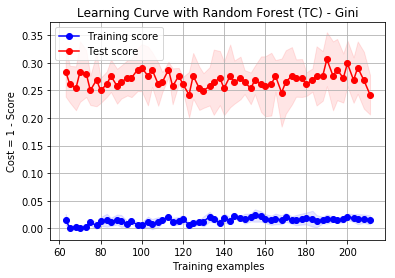

In [136]:
clf_rf_learning = RandomForestClassifier(criterion='gini',random_state=777)

title = 'Learning Curve with Random Forest (TC) - Gini'
plot_learning_curve(clf_rf_learning, title, x_train, y_train, cv=5, n_jobs=1, train_sizes=np.linspace(.3, 1.0, 60))

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


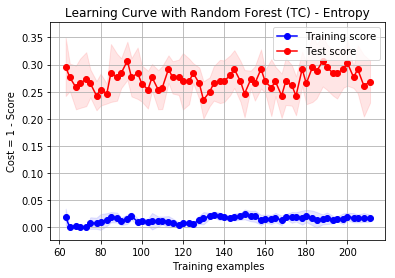

In [138]:
clf_rf_learning = RandomForestClassifier(criterion='entropy',random_state=777)

title = 'Learning Curve with Random Forest (TC) - Entropy'
plot_learning_curve(clf_rf_learning, title, x_train, y_train, cv=5, n_jobs=1, train_sizes=np.linspace(.3, 1.0, 60))

##### Plotting Validation Curves for # of Features

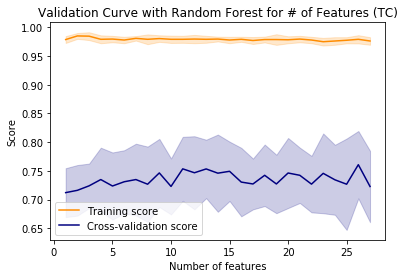

In [139]:
clf_rf_valid = RandomForestClassifier(criterion='gini',random_state=777)

param_range = [i for i in range(1,x_train.shape[1])]
train_scores, test_scores = validation_curve(
    clf_rf_valid, x_train, y_train, param_name="max_features", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Random Forest for # of Features (TC)"
xlabel = "Number of features"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for Minimum Samples Split

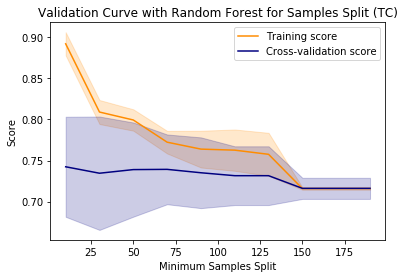

In [140]:
clf_rf_valid = RandomForestClassifier(criterion='gini',random_state=777)

param_range = list(range(10,200,20))
train_scores, test_scores = validation_curve(
    clf_rf_valid, x_train, y_train, param_name="min_samples_split", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Random Forest for Samples Split (TC)"
xlabel = "Minimum Samples Split"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for Maximum Depth

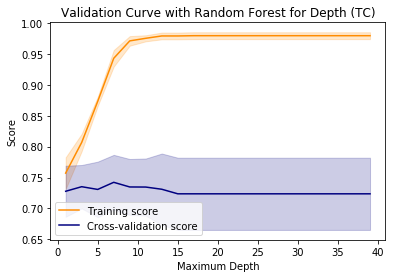

In [141]:
clf_rf_valid = RandomForestClassifier(criterion='gini',random_state=777)

param_range = list(range(1,40,2))
train_scores, test_scores = validation_curve(
    clf_rf_valid, x_train, y_train, param_name="max_depth", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Random Forest for Depth (TC)"
xlabel = "Maximum Depth"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

### Gradient Boosting Classifier (with Feature Scaling)

In [77]:
from sklearn.ensemble import GradientBoostingClassifier

In [79]:
# Set the parameters by cross-validation
parameters = {'min_samples_split' : range(10,200,20),'max_depth': range(1,10,2), 'max_features': range(1,28,2), 'learning_rate': range(1, 10, 100)}

print("# Tuning hyper-parameters for Gradient Boosting Classifier")
print()

clf_gbc = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10)
clf_gbc.fit(x_train, y_train)

print("Best parameters set found on Cross-Validation set:")
print()
print(clf_gbc.best_params_)
print()
print("Grid scores on training set:")
print()
means = clf_gbc.cv_results_['mean_test_score']
stds = clf_gbc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_gbc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for Gradient Boosting Classifier

Best parameters set found on Cross-Validation set:

{'learning_rate': 1, 'max_depth': 1, 'max_features': 11, 'min_samples_split': 190}

Grid scores on training set:

0.761 (+/-0.120) for {'learning_rate': 1, 'max_depth': 1, 'max_features': 1, 'min_samples_split': 10}
0.773 (+/-0.117) for {'learning_rate': 1, 'max_depth': 1, 'max_features': 1, 'min_samples_split': 30}
0.761 (+/-0.109) for {'learning_rate': 1, 'max_depth': 1, 'max_features': 1, 'min_samples_split': 50}
0.746 (+/-0.128) for {'learning_rate': 1, 'max_depth': 1, 'max_features': 1, 'min_samples_split': 70}
0.742 (+/-0.093) for {'learning_rate': 1, 'max_depth': 1, 'max_features': 1, 'min_samples_split': 90}
0.761 (+/-0.110) for {'learning_rate': 1, 'max_depth': 1, 'max_features': 1, 'min_samples_split': 110}
0.750 (+/-0.146) for {'learning_rate': 1, 'max_depth': 1, 'max_features': 1, 'min_samples_split': 130}
0.758 (+/-0.143) for {'learning_rate': 1, 'max_depth': 1, 

0.735 (+/-0.107) for {'learning_rate': 1, 'max_depth': 3, 'max_features': 23, 'min_samples_split': 90}
0.750 (+/-0.129) for {'learning_rate': 1, 'max_depth': 3, 'max_features': 23, 'min_samples_split': 110}
0.727 (+/-0.146) for {'learning_rate': 1, 'max_depth': 3, 'max_features': 23, 'min_samples_split': 130}
0.746 (+/-0.133) for {'learning_rate': 1, 'max_depth': 3, 'max_features': 23, 'min_samples_split': 150}
0.727 (+/-0.136) for {'learning_rate': 1, 'max_depth': 3, 'max_features': 23, 'min_samples_split': 170}
0.731 (+/-0.155) for {'learning_rate': 1, 'max_depth': 3, 'max_features': 23, 'min_samples_split': 190}
0.754 (+/-0.148) for {'learning_rate': 1, 'max_depth': 3, 'max_features': 25, 'min_samples_split': 10}
0.727 (+/-0.126) for {'learning_rate': 1, 'max_depth': 3, 'max_features': 25, 'min_samples_split': 30}
0.746 (+/-0.141) for {'learning_rate': 1, 'max_depth': 3, 'max_features': 25, 'min_samples_split': 50}
0.712 (+/-0.105) for {'learning_rate': 1, 'max_depth': 3, 'max_featu

##### Plotting Learning Curves

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


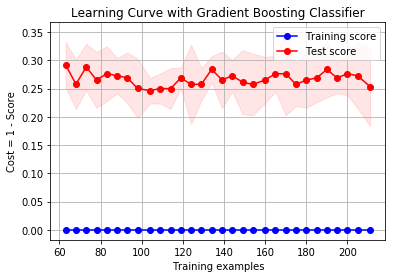

In [134]:
clf_gbc_learning = GradientBoostingClassifier(learning_rate=1, random_state=777)

title = 'Learning Curve with Gradient Boosting Classifier'
plot_learning_curve(clf_gbc_learning, title, x_train, y_train, cv=5, n_jobs=1, train_sizes=np.linspace(.3, 1.0, 30))

##### Plotting Validation Curves

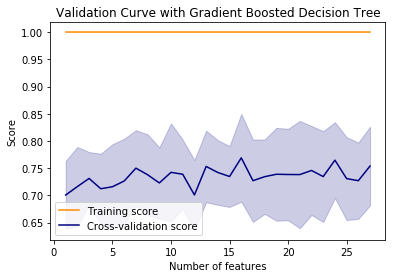

In [81]:
clf_gbc_valid = GradientBoostingClassifier(learning_rate=1, random_state=777)

param_range = [i for i in range(1,x_train.shape[1])]
train_scores, test_scores = validation_curve(
    clf_gbc_valid, x_train, y_train, param_name="max_features", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Gradient Boosted Decision Tree"
xlabel = "Number of features"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for Minimum Samples Split

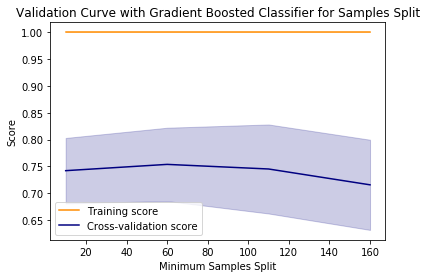

In [82]:
clf_gbc_valid = GradientBoostingClassifier(learning_rate=1,random_state=777)

param_range = list(range(10,200,50))
train_scores, test_scores = validation_curve(
    clf_gbc_valid, x_train, y_train, param_name="min_samples_split", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Gradient Boosted Classifier for Samples Split"
xlabel = "Minimum Samples Split"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for Maximum Depth

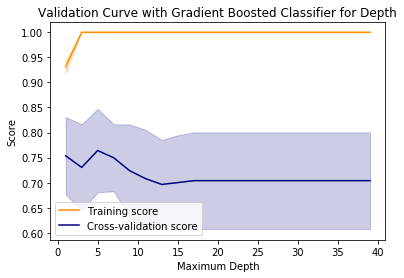

In [83]:
clf_gbc_valid = GradientBoostingClassifier(learning_rate=1,random_state=777)

param_range = list(range(1,40,2))
train_scores, test_scores = validation_curve(
    clf_gbc_valid, x_train, y_train, param_name="max_depth", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Gradient Boosted Classifier for Depth"
xlabel = "Maximum Depth"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for Learning Rates

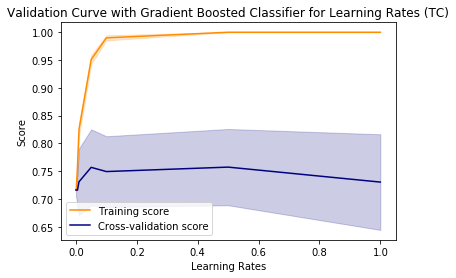

In [143]:
clf_gbc_valid = GradientBoostingClassifier(random_state=777)

param_range = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
train_scores, test_scores = validation_curve(
    clf_gbc_valid, x_train, y_train, param_name="learning_rate", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Gradient Boosted Classifier for Learning Rates (TC)"
xlabel = "Learning Rates"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

##### Plotting Validation Curves for N estimators

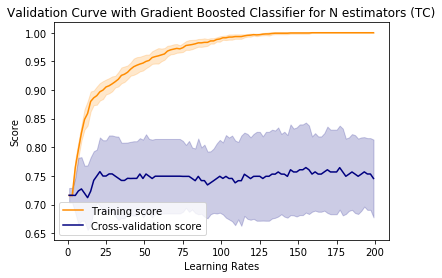

In [144]:
clf_gbc_valid = GradientBoostingClassifier(random_state=777)

param_range = list(range(1,200,2))
train_scores, test_scores = validation_curve(
    clf_gbc_valid, x_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
title = "Validation Curve with Gradient Boosted Classifier for N estimators (TC)"
xlabel = "Learning Rates"
plot_validation_curve_for_tree(train_scores, test_scores, title, xlabel, param_range)

#### Print Accuracy Rates (for Test Set)

In [85]:
print('Accuracy for SVM: {}'.format(clf.score(x_test, y_test)))
print('Accuracy for Decision Tree: {}'.format(clf_tree.score(x_test, y_test)))
print('Accuracy for Random Forest: {}'.format(clf_rf.score(x_test, y_test)))
print('Accuracy for Gradient Boosted Classifier: {}'.format(clf_gbc.score(x_test, y_test)))

Accuracy for SVM: 0.7862595419847328
Accuracy for Decision Tree: 0.7938931297709924
Accuracy for Random Forest: 0.7862595419847328
Accuracy for Gradient Boosted Classifier: 0.7633587786259542


#### Print Confusion Matrix for Classifiers

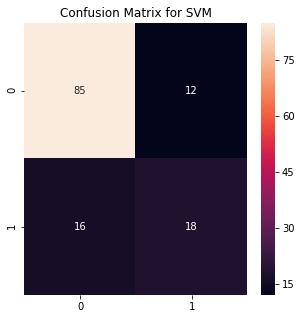

Sensitivity for SVM:  0.876
Specificity for SVM:  0.529
F Score for SVM:  0.562


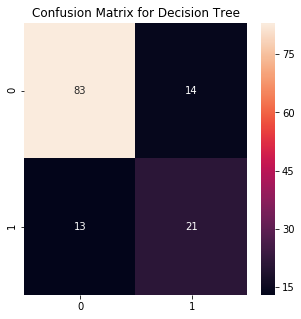

Sensitivity for Decision Tree:  0.856
Specificity for Decision Tree:  0.618
F Score for Decision Tree:  0.609


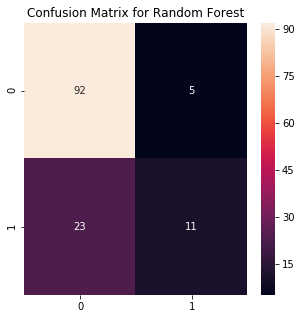

Sensitivity for Random Forest:  0.948
Specificity for Random Forest:  0.324
F Score for Random Forest:  0.44


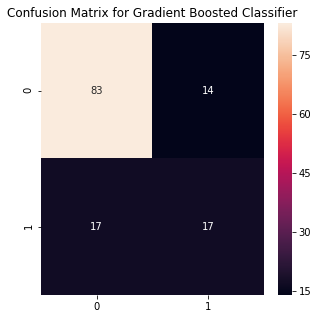

Sensitivity for Gradient Boosted Classifier:  0.856
Specificity for Gradient Boosted Classifier:  0.5
F Score for Gradient Boosted Classifier:  0.523


In [86]:
cm_svm = confusion_matrix(y_test, clf.predict(x_test))
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix for SVM')
sns.heatmap(cm_svm, annot=True)
plt.show()
sensitivity_svm = round(cm_svm[0,0]/(cm_svm[0,0]+cm_svm[0,1]),3)
print('Sensitivity for SVM: ', sensitivity_svm )
specificity_svm = round(cm_svm[1,1]/(cm_svm[1,0]+cm_svm[1,1]),3)
print('Specificity for SVM: ', specificity_svm)
f_score_svm = round(f1_score(y_test, clf.predict(x_test)),3)
print('F Score for SVM: ', f_score_svm)

cm_tree = confusion_matrix(y_test, clf_tree.predict(x_test))
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix for Decision Tree')
sns.heatmap(cm_tree, annot=True)
plt.show()
sensitivity_tree = round(cm_tree[0,0]/(cm_tree[0,0]+cm_tree[0,1]),3)
print('Sensitivity for Decision Tree: ', sensitivity_tree )
specificity_tree = round(cm_tree[1,1]/(cm_tree[1,0]+cm_tree[1,1]),3)
print('Specificity for Decision Tree: ', specificity_tree)
f_score_tree = round(f1_score(y_test, clf_tree.predict(x_test)),3)
print('F Score for Decision Tree: ', f_score_tree)

cm_rf = confusion_matrix(y_test, clf_rf.predict(x_test))
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix for Random Forest')
sns.heatmap(cm_rf, annot=True)
plt.show()
sensitivity_rf = round(cm_rf[0,0]/(cm_rf[0,0]+cm_rf[0,1]),3)
print('Sensitivity for Random Forest: ', sensitivity_rf )
specificity_rf = round(cm_rf[1,1]/(cm_rf[1,0]+cm_rf[1,1]),3)
print('Specificity for Random Forest: ', specificity_rf)
f_score_rf = round(f1_score(y_test, clf_rf.predict(x_test)),3)
print('F Score for Random Forest: ', f_score_rf)

cm_gbc = confusion_matrix(y_test, clf_gbc.predict(x_test))
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix for Gradient Boosted Classifier')
sns.heatmap(cm_gbc, annot=True)
plt.show()
sensitivity_gbc = round(cm_gbc[0,0]/(cm_gbc[0,0]+cm_gbc[0,1]),3)
print('Sensitivity for Gradient Boosted Classifier: ', sensitivity_gbc )
specificity_gbc = round(cm_gbc[1,1]/(cm_gbc[1,0]+cm_gbc[1,1]),3)
print('Specificity for Gradient Boosted Classifier: ', specificity_gbc)
f_score_gbc = round(f1_score(y_test, clf_gbc.predict(x_test)),3)
print('F Score for Gradient Boosted Classifier: ', f_score_gbc)

#### Print ROC Curve for Classifiers

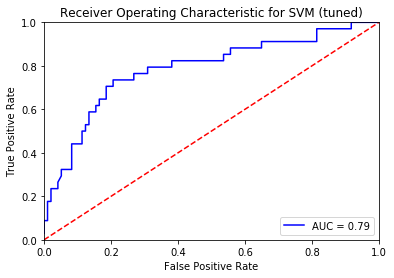

In [87]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for SVM (tuned)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

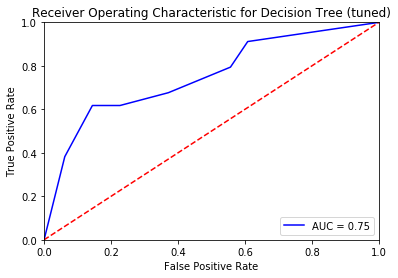

In [88]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_tree.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for Decision Tree (tuned)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

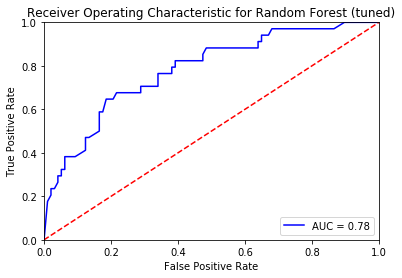

In [89]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_rf.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for Random Forest (tuned)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

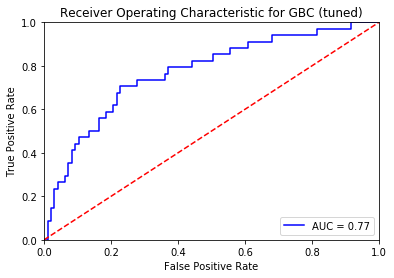

In [90]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_gbc.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for GBC (tuned)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/Wei

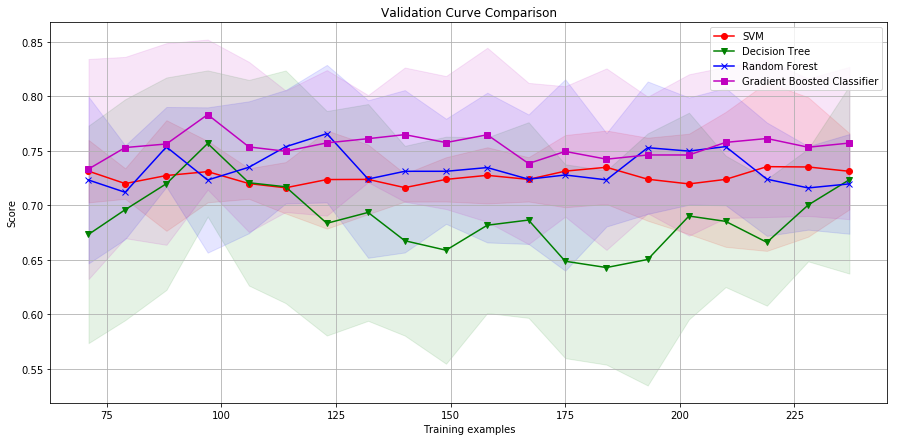

In [91]:
train_sizes = np.linspace(.3, 1.0, 20)
train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(clf_valid, x_train, y_train, cv=10, n_jobs=1, train_sizes=train_sizes)
train_sizes_tree, train_scores_tree, test_scores_tree = learning_curve(clf_tree_valid, x_train, y_train, cv=10, n_jobs=1, train_sizes=train_sizes)
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(clf_rf_valid, x_train, y_train, cv=10, n_jobs=1, train_sizes=train_sizes)
train_sizes_gbc, train_scores_gbc, test_scores_gbc = learning_curve(clf_gbc_valid, x_train, y_train, cv=10, n_jobs=1, train_sizes=train_sizes)

plt.figure(figsize=(15,7))
plt.title('Validation Curve Comparison')
plt.xlabel("Training examples")
plt.ylabel("Score")
test_scores_mean_svm = np.mean(test_scores_svm, axis=1)
test_scores_std_svm = np.std(test_scores_svm, axis=1)
test_scores_mean_tree = np.mean(test_scores_tree, axis=1)
test_scores_std_tree = np.std(test_scores_tree, axis=1)
test_scores_mean_rf = np.mean(test_scores_rf, axis=1)
test_scores_std_rf = np.std(test_scores_rf, axis=1)
test_scores_mean_gbc = np.mean(test_scores_gbc, axis=1)
test_scores_std_gbc = np.std(test_scores_gbc, axis=1)

plt.fill_between(train_sizes_svm, test_scores_mean_svm - test_scores_std_svm,
                 test_scores_mean_svm + test_scores_std_svm, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_tree, test_scores_mean_tree - test_scores_std_tree,
                 test_scores_mean_tree + test_scores_std_tree, alpha=0.1, color="g")
plt.fill_between(train_sizes_rf, test_scores_mean_rf - test_scores_std_rf,
                 test_scores_mean_rf + test_scores_std_rf, alpha=0.1, color="b")
plt.fill_between(train_sizes_gbc, test_scores_mean_gbc - test_scores_std_gbc,
                 test_scores_mean_gbc + test_scores_std_gbc, alpha=0.1, color="m")


plt.plot(train_sizes_svm, test_scores_mean_svm, 'o-', color="r",
         label="SVM")
plt.plot(train_sizes_tree, test_scores_mean_tree, 'v-', color="g",
         label="Decision Tree")
plt.plot(train_sizes_rf, test_scores_mean_rf, 'x-', color="b",
         label="Random Forest")
plt.plot(train_sizes_gbc, test_scores_mean_gbc, 's-', color="m",
         label="Gradient Boosted Classifier")

plt.grid()
plt.legend(loc="best")